# Test GEModelTools - HANK

This notebook shows how to **solve a simple Heterogenous Agent New Keynessian (HANK) model** using the `GEModelTools` package.

**The steps of the sequence-space solution method are:**

1. Find the stationary equilibrium (steady state for aggregates and distribution).
2. Compute Jacobians of the household block and the full model (to unknowns and shocks)
3. Find the non-linear transition path or the linearized impulse responses to a given shock path.
4. Simulate the linearized model with aggregate risk

# Imports

In [96]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
import sys
from scipy import optimize

import matplotlib.pyplot as plt   
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
#np.set_printoptions(threshold=sys.maxsize)

from HANKmodel import HANKModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup

In [97]:
#print(model)
model = HANKModelClass(name='baseline')
#model.print_unpack_varlist()

# Step 1: Steady state

In [98]:
model.find_ss(do_print=True)

steady state found in 22.6 secs
 Q   =   0.7235
 P   =   0.8136
 Z_N   =   0.2591
 Z_L   =   0.9977
 M_N   =   0.3121
 M_L   =   0.1242
 N_L   =   0.4029
 N_N   =   0.5469
 HH_ell   =   1.1301
 wage N  =   0.2757
 wage L  =   0.3811
 par.varphi   =   1.0000
 par.beta   =   0.9716
Discrepancy in B =   0.00000000
Discrepancy in C =   0.00000000
Discrepancy in C_L =   0.00000000
Discrepancy in C_N =   0.00000000
Discrepancy in N =  -0.00000000


In [99]:
par = model.par
ss = model.ss
path = model.path
sim = model.sim

Distribution graphs:

Average expenditures share on luxuries (in the data = 51.8%) =   0.5459
Average Subsistence share of expenditures (in the data = 22.4%) =   0.1004
Lowest income household subsistence share of expenditures (in the data = 43,5%) =   0.4974
Average expenditures share on necessities for the lowest income households (in the data = 70.5%): =   0.6950
Average expenditures share on necessities (in the data = 48.2%) =   0.4541
Average expenditures share on necessities, net of subsistence (in the data = 33.2%) =   0.3537


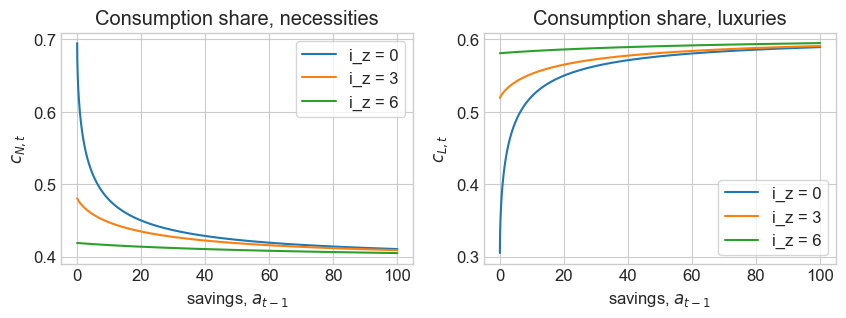

In [100]:
fig = plt.figure(figsize=(10,3),dpi=100)
a_max = 500

# a. necessity consumption share
I = par.a_grid < a_max

ax = fig.add_subplot(1,2,1)
ax.set_title(f'Consumption share, necessities')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.c_N[0,i_z,I]/(ss.P*ss.c[0,i_z,I]),label=f'i_z = {i_z}')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('$c_{N,t}$')

# a. luxury consumption share
I = par.a_grid < a_max

ax = fig.add_subplot(1,2,2)
ax.set_title(f'Consumption share, luxuries')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.Q*ss.c_L[0,i_z,I]/(ss.P*ss.c[0,i_z,I]),label=f'i_z = {i_z}')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('$c_{L,t}$')

print(f'Average expenditures share on luxuries (in the data = 51.8%) = {(ss.C_L*ss.Q/(ss.P*ss.C)):8.4f}')
print(f'Average Subsistence share of expenditures (in the data = 22.4%) = {(par.c_bar/(ss.P*ss.C)):8.4f}')
print(f'Lowest income household subsistence share of expenditures (in the data = 43,5%) = {(par.c_bar/(ss.P*np.average(ss.c[0,0,0]))):8.4f}')
print(f'Average expenditures share on necessities for the lowest income households (in the data = 70.5%): = {(np.average(ss.c_N[0,0,0]))/(ss.P*np.average(ss.c[0,0,0])):8.4f}')
print(f'Average expenditures share on necessities (in the data = 48.2%) = {(ss.C_N/(ss.P*ss.C)):8.4f}')
print(f'Average expenditures share on necessities, net of subsistence (in the data = 33.2%) = {(ss.C_HAT_N_hh/(ss.P*ss.C)):8.4f}')

Marginal propensities to consume

mean MPC: 0.074 [annual: 0.265]


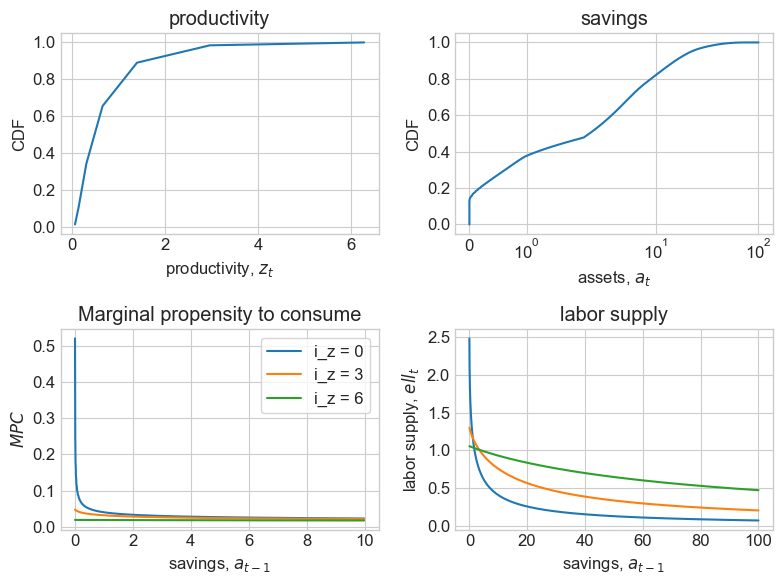

In [101]:
MPC = np.zeros(ss.D.shape)
m_diff = (1+ss.r)*par.a_grid[np.newaxis,np.newaxis,1:]-(1+model.ss.r)*par.a_grid[np.newaxis,np.newaxis,:-1]
MPC[:,:,:-1] = (ss.c[:,:,1:]-ss.c[:,:,:-1])/m_diff
MPC[:,:,-1] = MPC[:,:,-1] # assuming constant MPC at end
mean_MPC = np.sum(MPC*ss.D)
mean_MPC_ann = 1-(1-mean_MPC)**4
print(f'mean MPC: {mean_MPC:.3f} [annual: {mean_MPC_ann:.3f}]')

fig = plt.figure(figsize=(8,6),dpi=100)

# a. income
ax = fig.add_subplot(2,2,1)
ax.set_title('productivity')

y = np.cumsum(np.sum(ss.D[0],axis=1))
ax.plot(par.z_grid,y/y[-1])

ax.set_xlabel('productivity, $z_{t}$')
ax.set_ylabel('CDF')

# b. assets
ax = fig.add_subplot(2,2,2)
ax.set_title('savings')
y = np.insert(np.cumsum(np.sum(ss.D[0],axis=0)),0,0.0)
ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),y/y[-1])
        
ax.set_xlabel('assets, $a_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')

# c. MPC
I = par.a_grid < 10

ax = fig.add_subplot(2,2,3)
ax.set_title(f'Marginal propensity to consume')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],MPC[0,i_z,I],label=f'i_z = {i_z}')
ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('$MPC$')


# D. labor supply
I = par.a_grid < a_max

ax = fig.add_subplot(2,2,4)
ax.set_title(f'labor supply')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.ell[0,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('labor supply, $ell_{t}$')

fig.tight_layout()

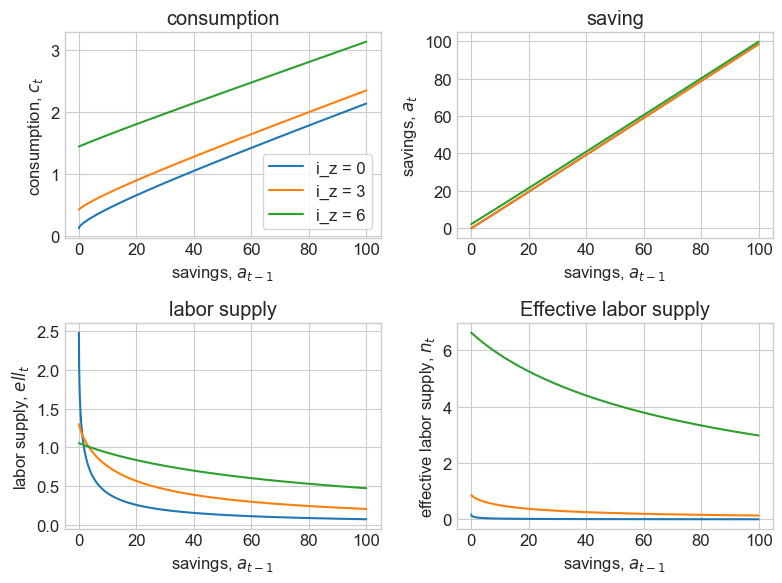

In [102]:
fig = plt.figure(figsize=(8,6),dpi=100)
a_max = 500

# a. consumption
I = par.a_grid < a_max

ax = fig.add_subplot(2,2,1)
ax.set_title(f'consumption')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.c[0,i_z,I],label=f'i_z = {i_z}')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('consumption, $c_t$')

# b. saving
I = par.a_grid < a_max

ax = fig.add_subplot(2,2,2)
ax.set_title(f'saving')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.a[0,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('savings, $a_{t}$')

# c. labor supply
I = par.a_grid < a_max

ax = fig.add_subplot(2,2,3)
ax.set_title(f'labor supply')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.ell[0,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('labor supply, $ell_{t}$')


# c. labor supply
I = par.a_grid < a_max

ax = fig.add_subplot(2,2,4)
ax.set_title(f'Effective labor supply')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.n[0,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('effective labor supply, $n_{t}$')

fig.tight_layout()

# Step 2: Compute Jacobians (incl. tests)

**Household transition path:**

note: inputs = steady state value -> expected: constant value (straigt line)

household problem solved along transition path in 0.3 secs
household problem simulated along transition in 2.4 secs



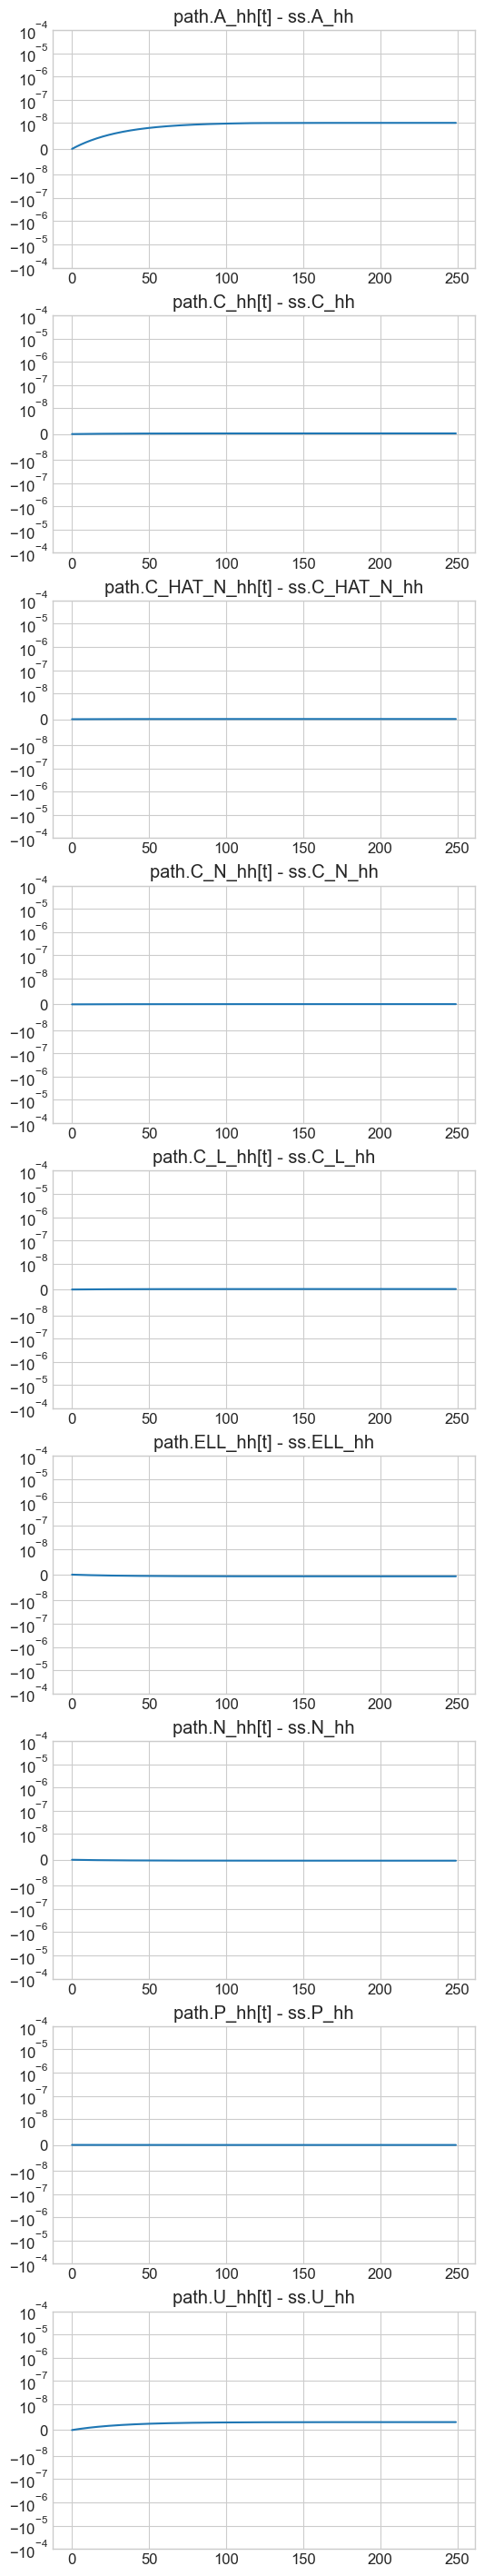

In [103]:
model.test_hh_path()

**Full transition path:**

In [104]:
model.test_path()

note: inputs = steady state value -> expected: no difference to steady state and zero errors

difference to value at steady state:
A              : t0 =  0.0e+00, max abs.  0.0e+00
B              : t0 =  0.0e+00, max abs.  0.0e+00
C              : t0 =  0.0e+00, max abs.  0.0e+00
C_N            : t0 = -5.6e-17, max abs.  5.6e-17
C_L            : t0 =  0.0e+00, max abs.  0.0e+00
d_N            : t0 =  0.0e+00, max abs.  0.0e+00
d_L            : t0 =  5.6e-17, max abs.  5.6e-17
G              : t0 = -6.9e-18, max abs.  6.9e-18
i              : t0 =  0.0e+00, max abs.  0.0e+00
N              : t0 =  0.0e+00, max abs.  0.0e+00
N_N            : t0 =  0.0e+00, max abs.  0.0e+00
N_L            : t0 =  0.0e+00, max abs.  0.0e+00
M_N            : t0 =  0.0e+00, max abs.  0.0e+00
M_L            : t0 =  0.0e+00, max abs.  0.0e+00
pm_L           : t0 =  0.0e+00, max abs.  0.0e+00
pm_N           : t0 =  0.0e+00, max abs.  0.0e+00
p_N            : t0 =  0.0e+00, max abs.  0.0e+00
p_L            : t0

In [105]:
model.compute_jacs(do_print=True)
#model.test_jacs(s_list=[50,100,150])

household Jacobians:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for P               in 0.5 secs
curly_Y and curly_D calculated for Q               in 0.5 secs
curly_Y and curly_D calculated for d_L             in 0.5 secs
curly_Y and curly_D calculated for d_N             in 0.5 secs
curly_Y and curly_D calculated for p_L             in 0.5 secs
curly_Y and curly_D calculated for p_N             in 0.5 secs
curly_Y and curly_D calculated for r               in 0.5 secs
curly_Y and curly_D calculated for tau             in 0.5 secs
curly_Y and curly_D calculated for w_N             in 0.5 secs
curly_E calculated in 0.1 secs
builiding blocks combined in 0.3 secs
household Jacobian computed in 5.0 secs

full Jacobians:
full Jacobian to unknowns computed in 1.0 secs [in evaluate_path(): 0.6 secs]
full Jacobian to shocks computed in 0.9 secs [in evaluate_path(): 0.6 secs]


# Step 3a: Find non-linear transition path

## Find transition path

In [106]:
#par.jump_istar = 0.0025 # Monetary policy shock
#par.jump_istar = 0.0025 # Monetary policy shock reset
par.jump_pm_N     = 0.01 # cost push shock
model.find_transition_path(do_print=True) #all

finding the transition path:
 it =   0 -> max. abs. error = 2.70e-02
   3.45e-03 in NKPC_res_N
   3.43e-04 in NKPC_res_L
   2.70e-02 in clearing_A
   1.98e-03 in clearing_N
   2.93e-03 in clearing_C_N
 it =   1 -> max. abs. error = 6.18e-04
   1.56e-05 in NKPC_res_N
   1.96e-06 in NKPC_res_L
   6.18e-04 in clearing_A
   6.34e-05 in clearing_N
   1.01e-04 in clearing_C_N
 it =   2 -> max. abs. error = 1.07e-05
   4.31e-07 in NKPC_res_N
   3.32e-07 in NKPC_res_L
   1.07e-05 in clearing_A
   5.74e-06 in clearing_N
   3.44e-06 in clearing_C_N
 it =   3 -> max. abs. error = 1.99e-07
   1.55e-08 in NKPC_res_N
   6.46e-09 in NKPC_res_L
   1.99e-07 in clearing_A
   7.24e-08 in clearing_N
   2.04e-08 in clearing_C_N
 it =   4 -> max. abs. error = 3.32e-09
   4.88e-10 in NKPC_res_N
   1.61e-10 in NKPC_res_L
   3.32e-09 in clearing_A
   2.47e-09 in clearing_N
   4.66e-10 in clearing_C_N
 it =   5 -> max. abs. error = 8.49e-11
   1.46e-11 in NKPC_res_N
   3.05e-12 in NKPC_res_L
   2.00e-11 in clea

## Plot transitions

Show all graphs

### shocks ###


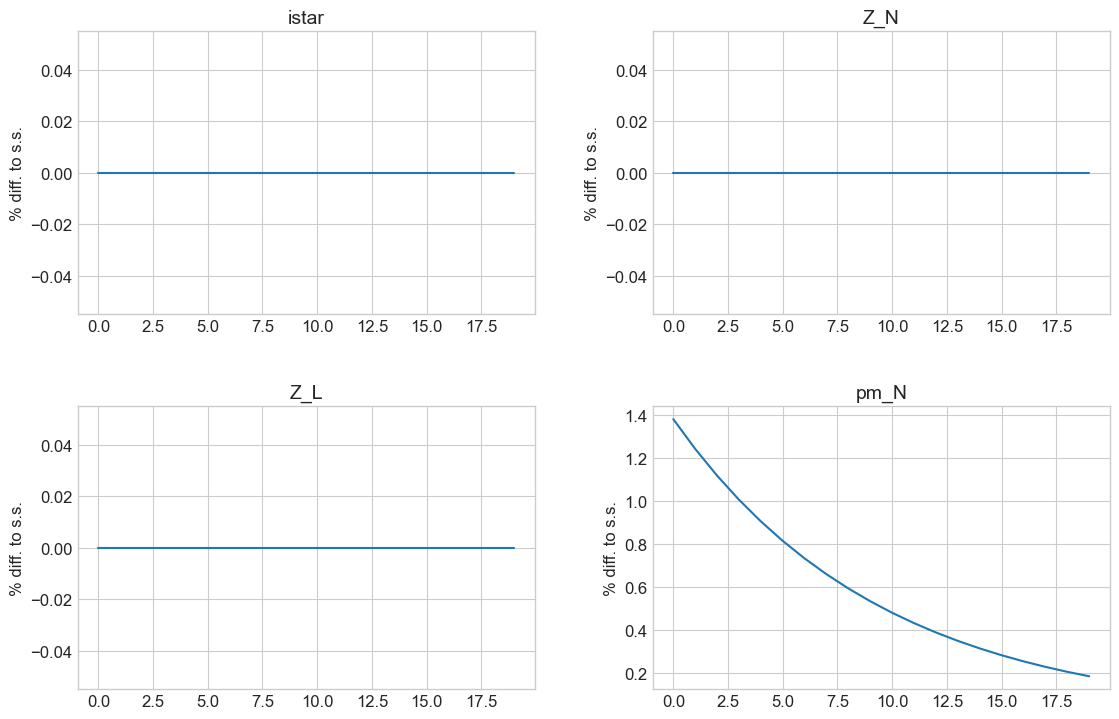


### varnames ###


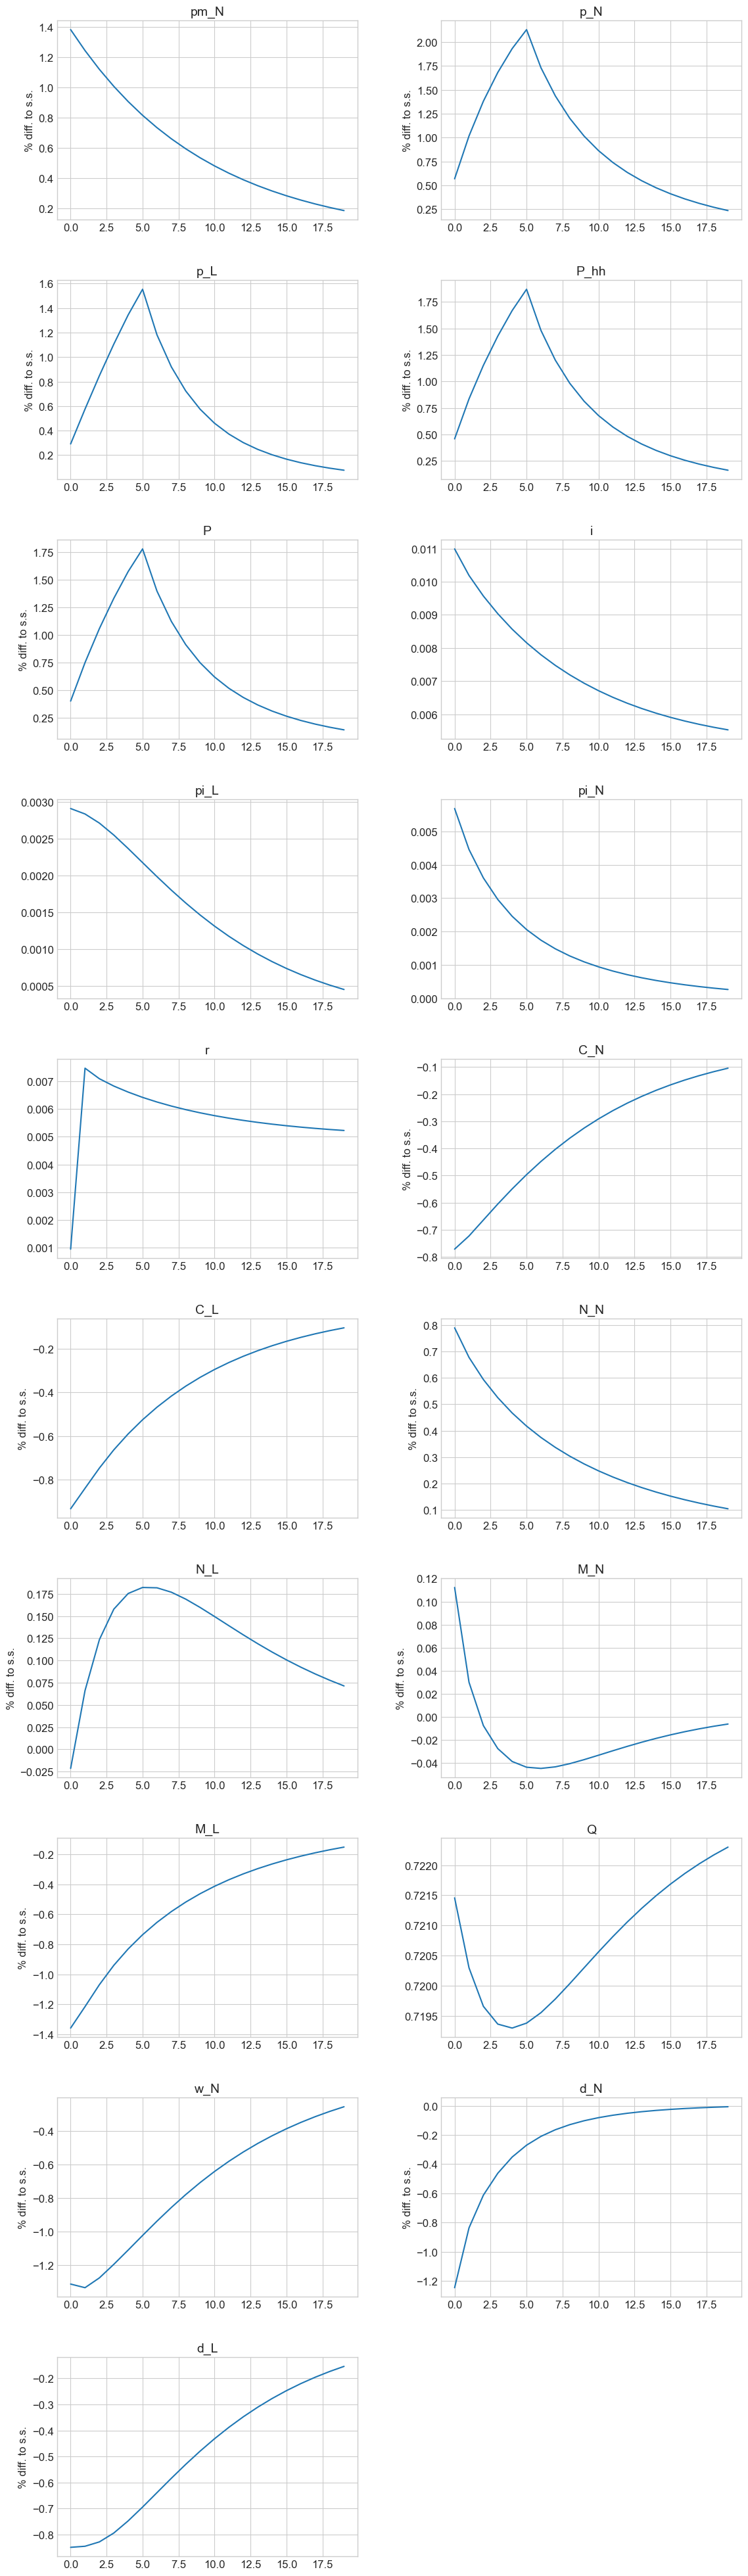


### tagets ###


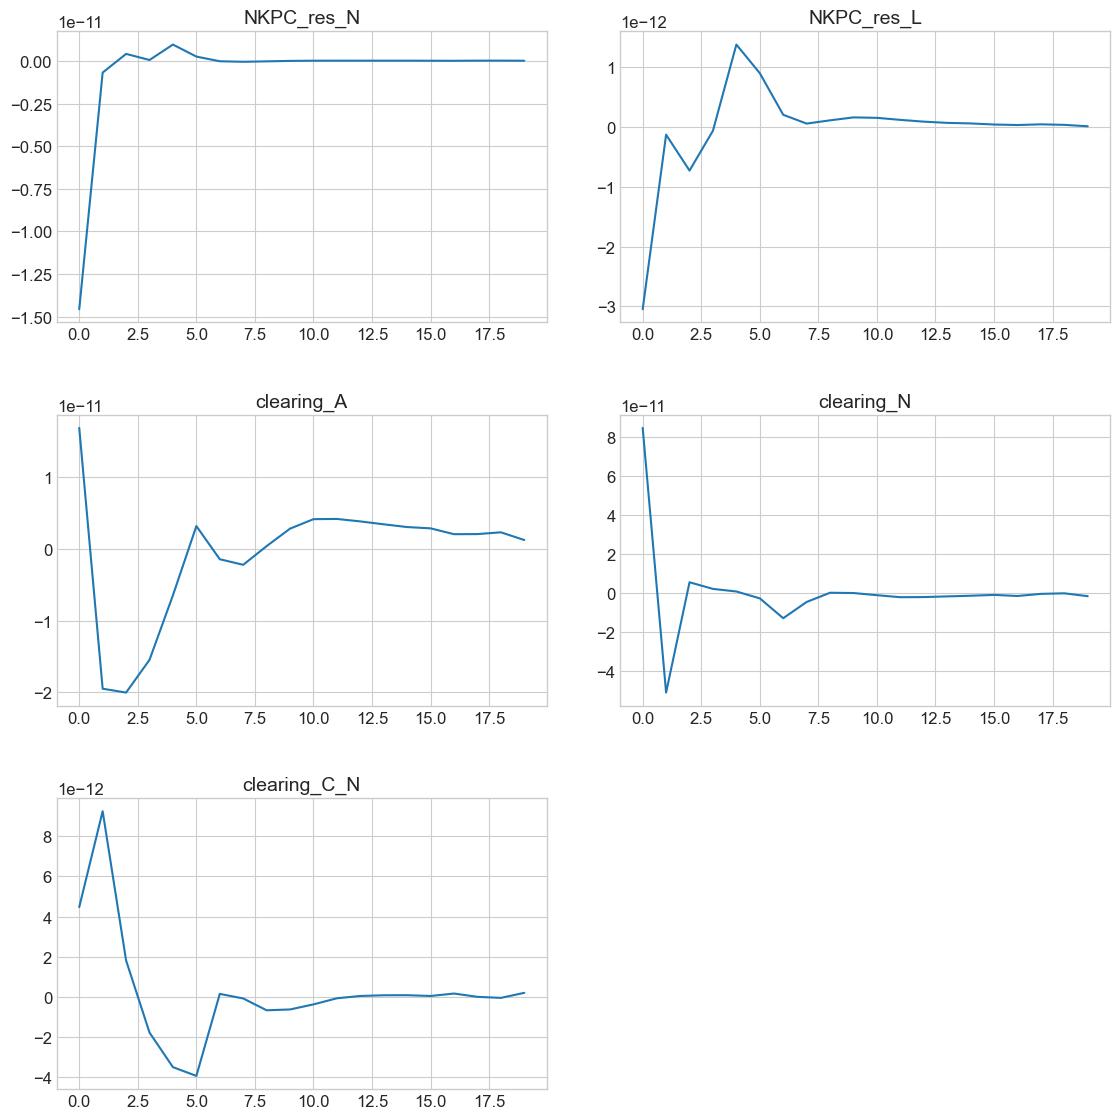

In [107]:


#paths = ['pm_N','i','pi_L','pi_N','r','pi','Y','C','C_N','C_L','N_hh','N_N','N_L','M_N','M_L','P','Q','w_N','w_L','d_N','d_L','P_hh'] 
#lvl_value = ['i','pi_L','pi_N','r','pi'] Show all push
# Select
paths = ['pm_N','p_N','p_L','P_hh','P','i','pi_L','pi_N','r','C_N','C_L','N_N','N_L','M_N','M_L','Q','w_N','d_N','d_L'] #Show all graphs
lvl_value = ['i','pi_L','pi_N','Q','r','pi'] #Show all push
model.show_IRFs(paths,lvl_value=lvl_value,T_max=20,ncols=2)


## Find effect of parameter change

### varnames ###


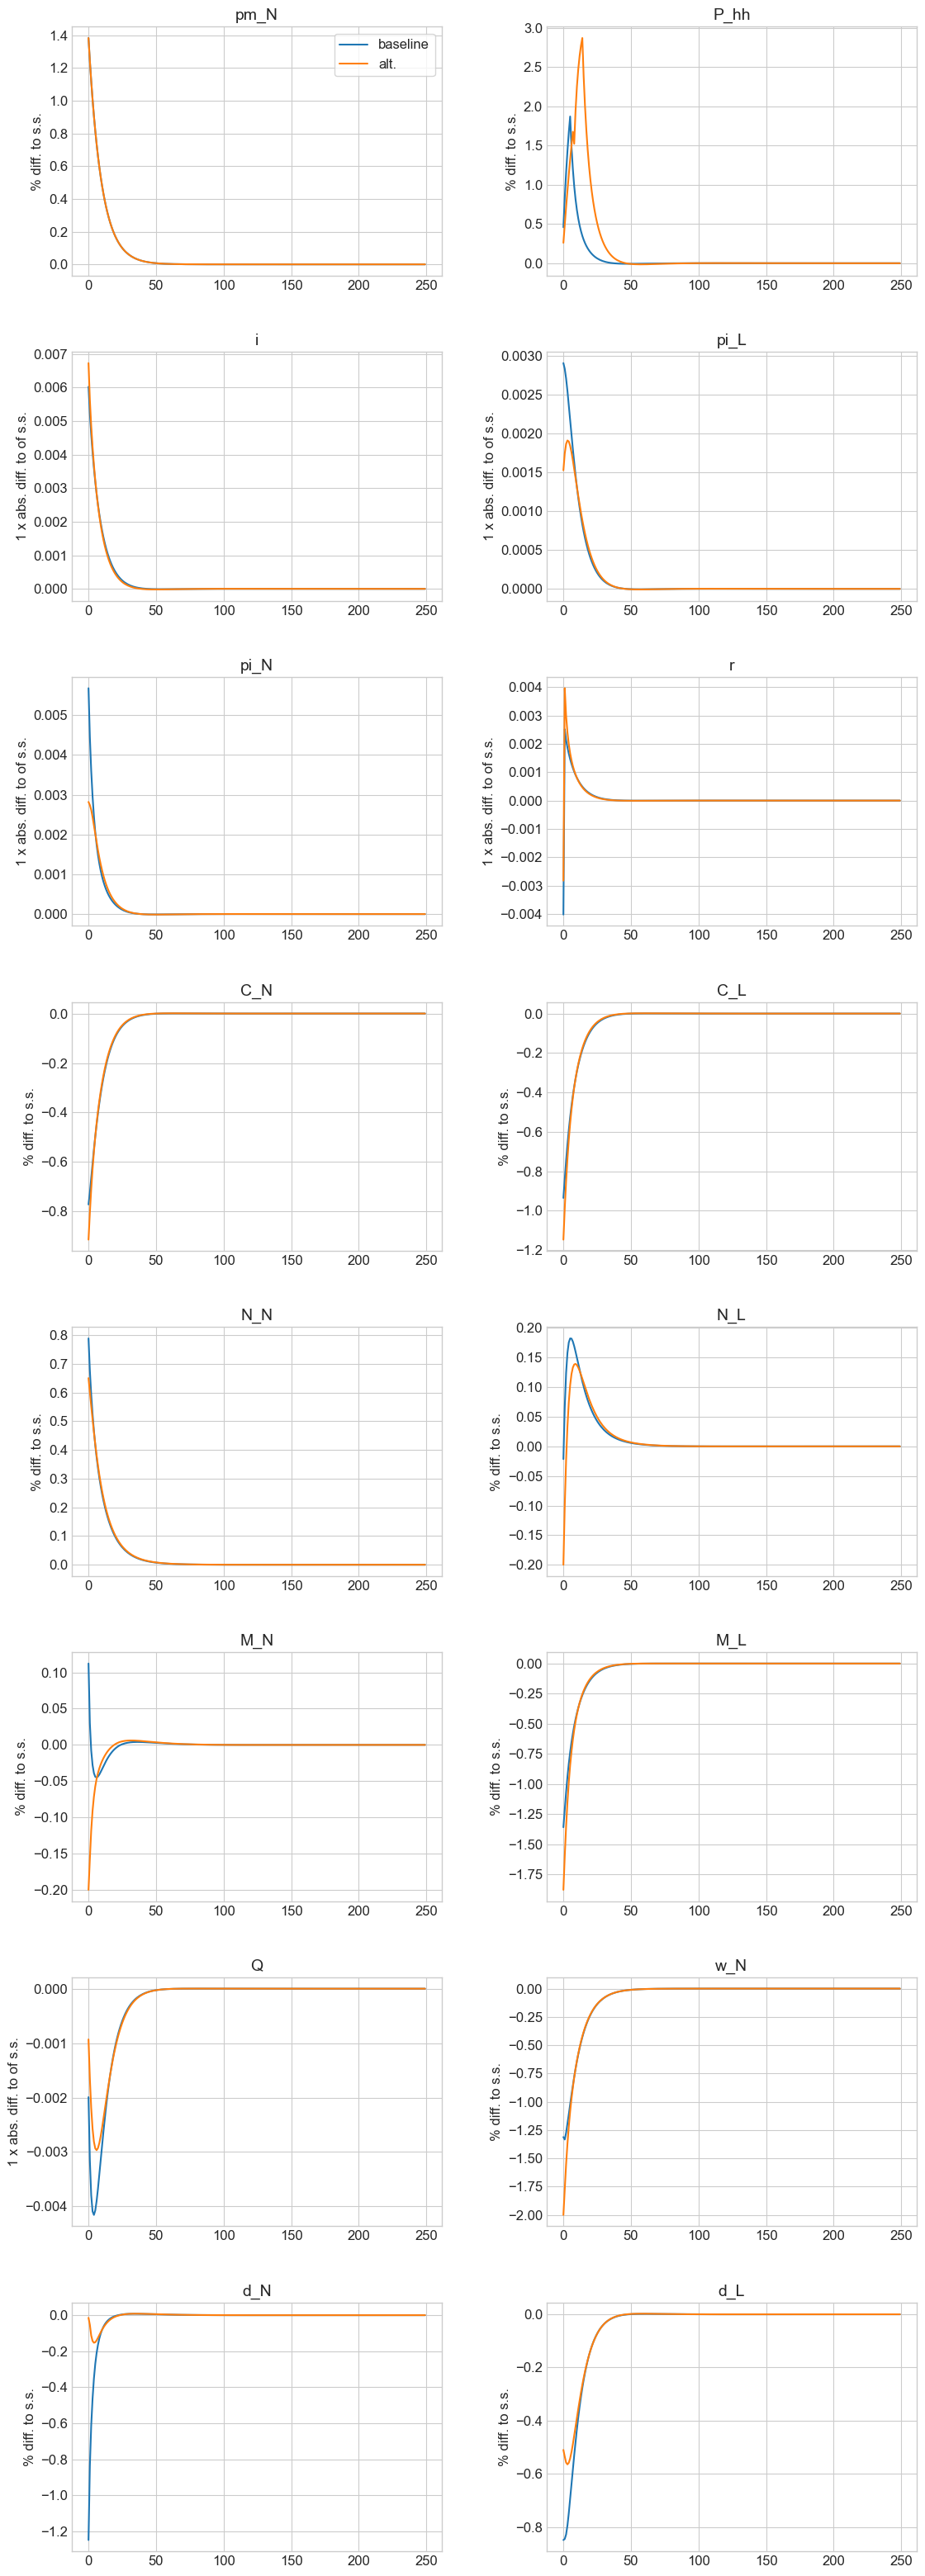

In [108]:
model_ = model.copy()
model_.par.epsilon = 1.0
model_.par.jump_istar = 0.0025 # Monetary policy shock reset
#model_.par.jump_pm_N     = 0.01 # cost push shock
# model_.find_ss()
model_.compute_jacs()
model_.find_transition_path()
paths = ['pm_N','P_hh','i','pi_L','pi_N','r','C_N','C_L','N_N','N_L','M_N','M_L','Q','w_N','d_N','d_L']
model.compare_IRFs([model,model_],['baseline','alt.'],paths,lvl_value,do_shocks=False,do_targets=False,ncols=2)

Behavior for a subset of households. Here those with zero assets.

['w_N']
household problem solved along transition path in 0.3 secs
household problem simulated along transition in 0.0 secs

['r']
household problem solved along transition path in 0.3 secs
household problem simulated along transition in 0.0 secs

['d_N']
household problem solved along transition path in 0.3 secs
household problem simulated along transition in 0.0 secs

['d_L']
household problem solved along transition path in 0.3 secs
household problem simulated along transition in 0.1 secs

['tau']
household problem solved along transition path in 0.3 secs
household problem simulated along transition in 0.0 secs

['P']
household problem solved along transition path in 0.3 secs
household problem simulated along transition in 0.0 secs

['Q']
household problem solved along transition path in 0.3 secs
household problem simulated along transition in 0.0 secs

None
household problem solved along transition path in 0.3 secs
household problem simulated along transition in 0.0 secs

all
house

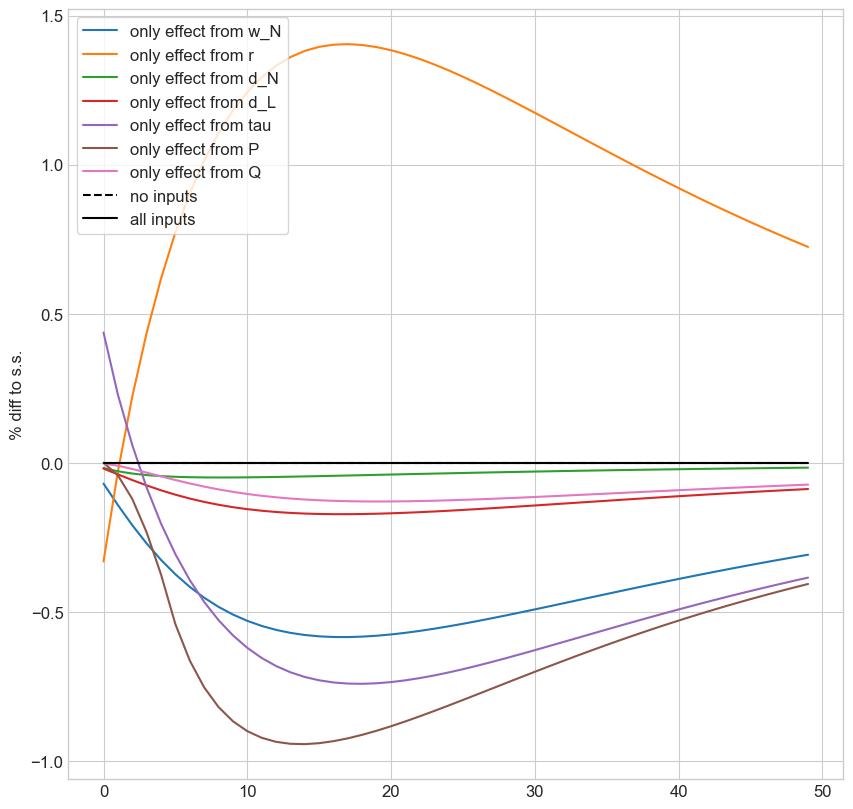

In [109]:
T_max = 50

fig = plt.figure(figsize=(10,10),dpi=100)
ax = fig.add_subplot(1,1,1)
    
i_color = 0
for use_inputs in [['w_N'],['r'],['d_N'],['d_L'],['tau'],['P'],['Q'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=True,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.A_hh[0,:50]/ss.A_hh-1)*100,ls=ls,color=color,label=label);

ax.set_ylabel('% diff to s.s.')
ax.legend(frameon=True);

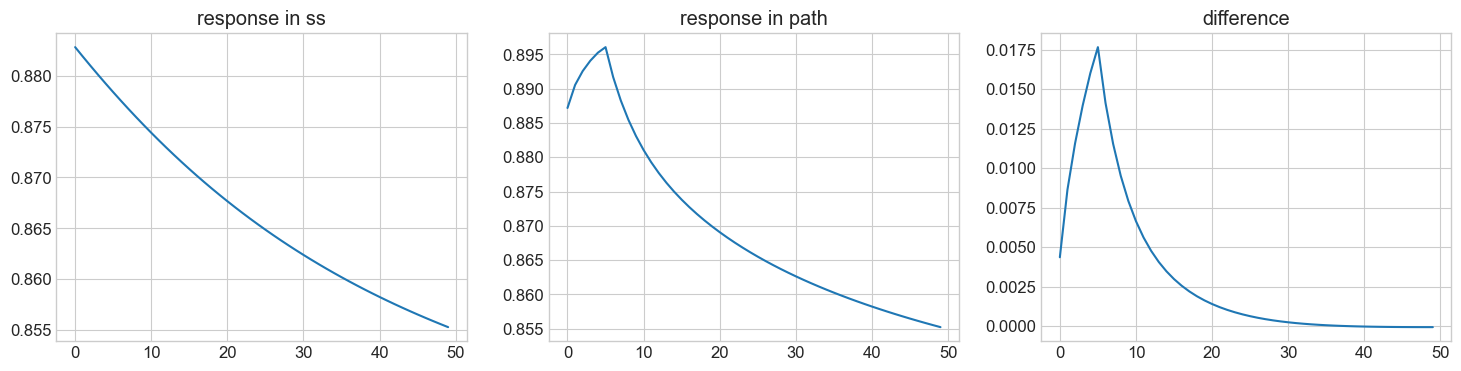

In [110]:
T_max = 50

fig = plt.figure(figsize=(3*6,4),dpi=100)
    
Dbeg = ss.Dbeg.copy()
Dbeg[:,1:,1:] = 0.0 # zero every else than in first asset grid point
#Dbeg[:,:6,:490] = 0.0 # zero every else than in last 50 asset grid points
Dbeg /= np.sum(Dbeg) # re-normalize

path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
path_alt = model.decompose_hh_path(Dbeg=Dbeg,use_inputs='all') 

ax = fig.add_subplot(1,3,1)
ax.set_title('response in ss')
ax.plot(path_alt_ss.P_hh[0,:50]);

ax = fig.add_subplot(1,3,2)
ax.set_title('response in path')
ax.plot(path_alt.P_hh[0,:50]);

ax = fig.add_subplot(1,3,3)
ax.set_title('difference')
ax.plot(path_alt.P_hh[0,:50]-path_alt_ss.P_hh[0,:50]);
Dbeg = ss.Dbeg.copy() #reset dbeg value





# Step 3b: Find linearized IRFs

In [111]:
model.find_IRFs(do_print=True)

linear transition path found in 0.2 secs [finding solution matrix: 0.2 secs]


### shocks ###


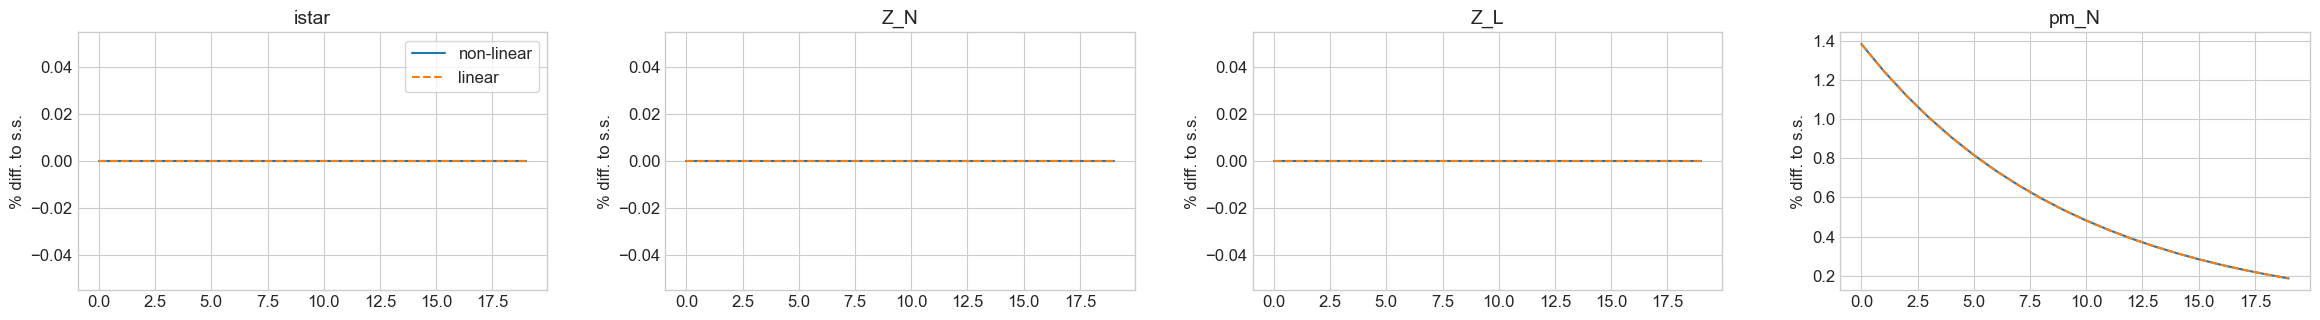


### varnames ###


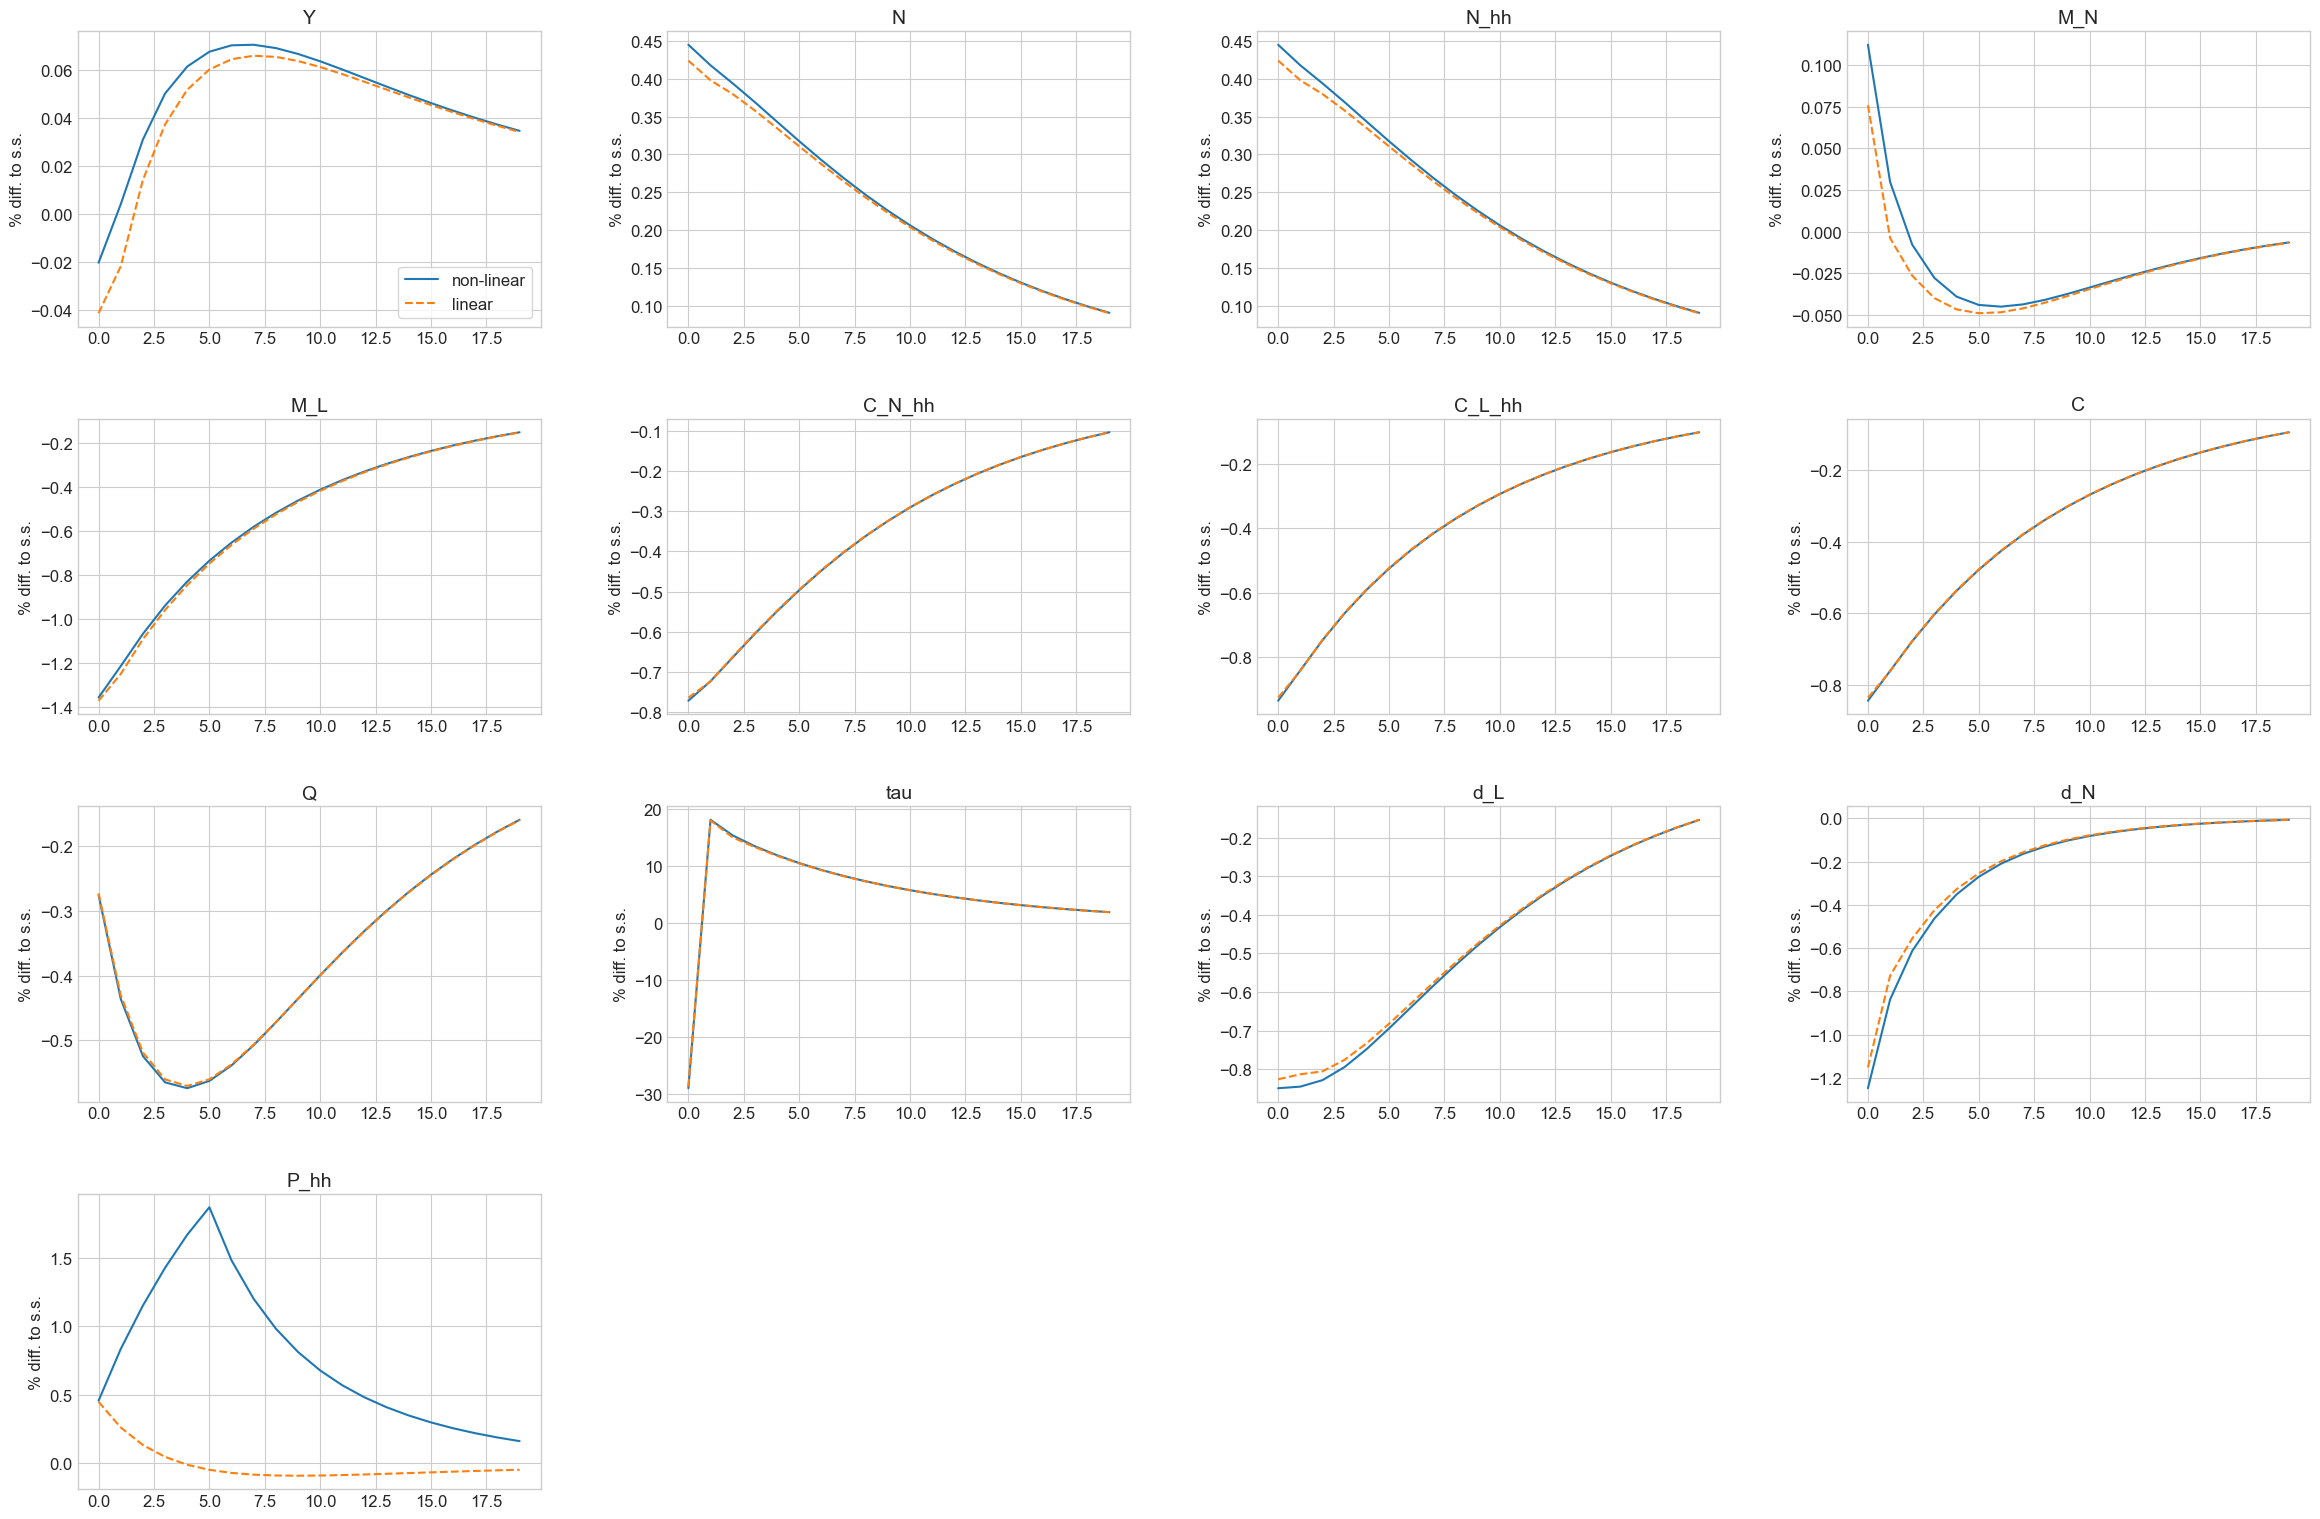


### tagets ###


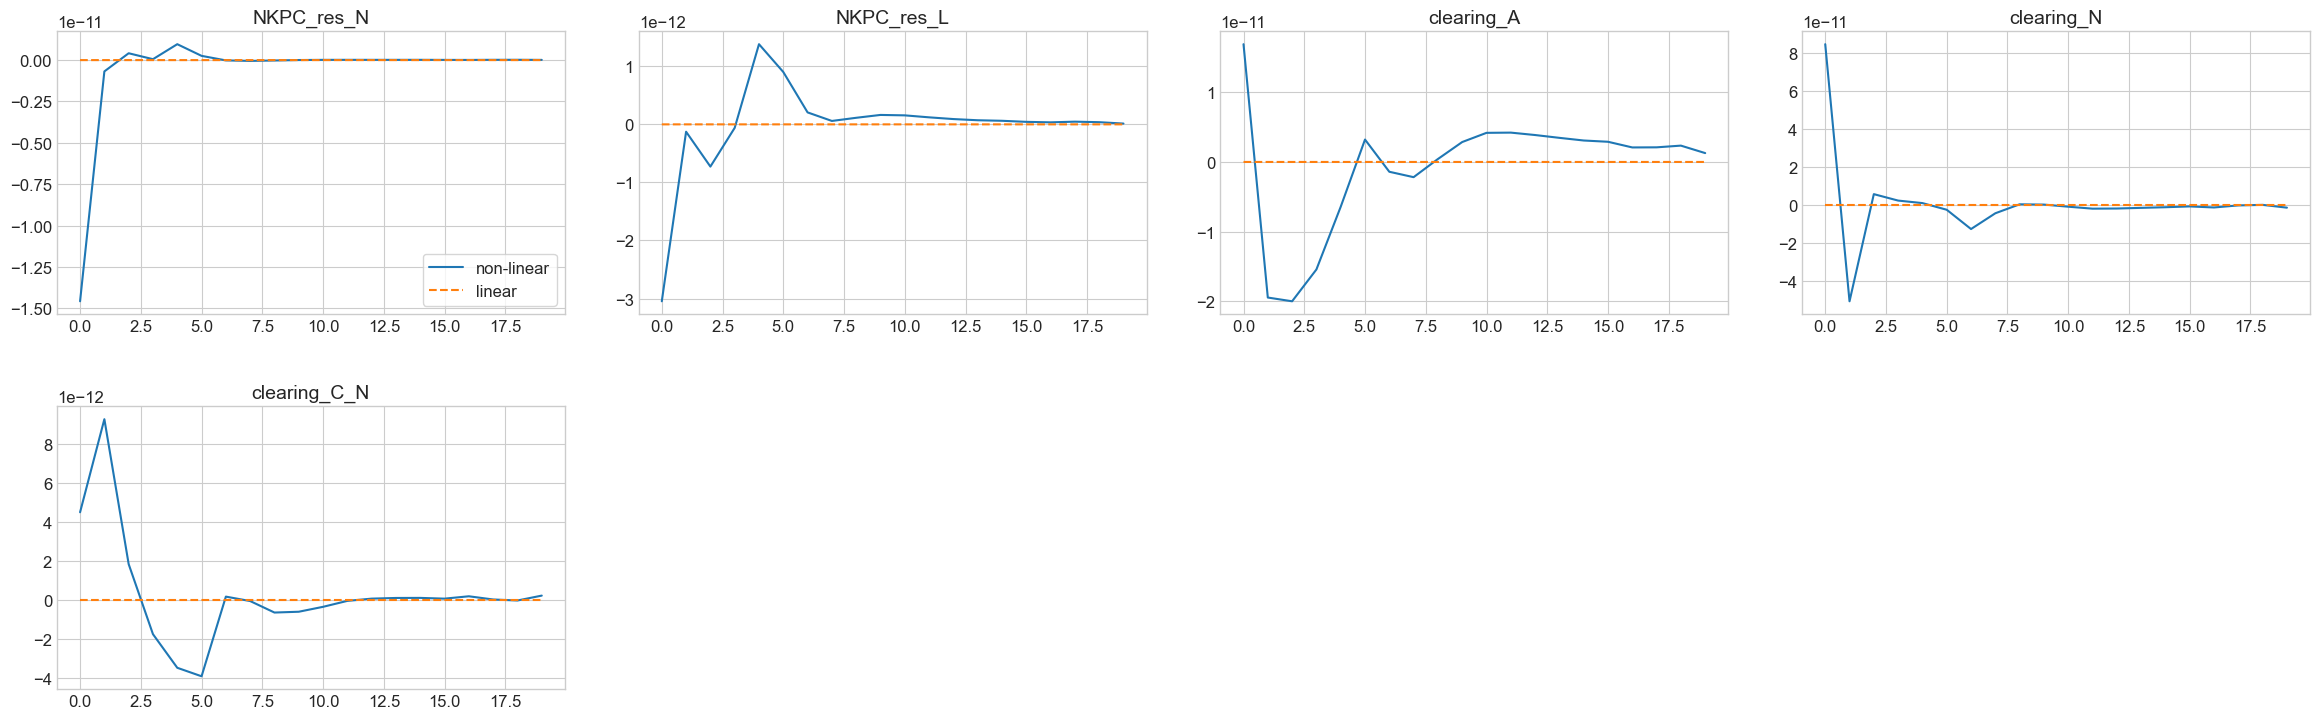

In [112]:
paths = ['Y','N','N_hh','M_N','M_L','C_N_hh','C_L_hh','C','Q','tau','d_L','d_N','P_hh']
model.show_IRFs(paths,T_max=20,ncols=4,do_linear=True)

In [113]:
#model_ = model.copy()
#model_.par_phi_y = 1.0
#model_.find_ss
#model_.compute_jacs()
#model_.find_transition_path()

# Step 4. Simulation

In [114]:
#np.random.seed(1917)
#model.simulate(do_print=True)

In [115]:
#def model_sim():
#    
#    fig = plt.figure(figsize=(12,8),dpi=100)
#
#    ax = fig.add_subplot(2,2,1)
#    ax.set_title('i')
#    ax.plot(ss.i+sim.di,ls='--')
#    ax.axhline(ss.i,color='black',zorder=0)
#
#    ax = fig.add_subplot(2,2,2)
#    ax.set_title('pi')
#    ax.plot(ss.pi+sim.dpi,ls='--',)
#    ax.axhline(ss.pi,color='black',zorder=0)
#    
#    ax = fig.add_subplot(2,2,3)
#    ax.set_title('r')
#    ax.plot(ss.r+sim.dr,ls='--',)
#    ax.axhline(ss.r,color='black',zorder=0)
#    
#    ax = fig.add_subplot(2,2,4)
#    ax.set_title('C')
#    ax.plot(ss.C+sim.dC,ls='--',)
#    ax.axhline(ss.C,color='black',zorder=0)
    

In [116]:
#model_sim()